In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon import LQ
from DynLinEcon import DLE
%matplotlib inline

//anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# Growth in Dynamic Linear Economies

This notebook describes a class of complete market economies that exhibit a common linear-quadratic-Gaussian structure. Three examples of such economies are given, to show how the DLE class can be used to solve such economies in Python, and to show how different economies can or cannot generate sustained growth.

### Common structure of economies

Economies in this class are defined by the following features:

* Information flows are governed by an exogenous stochastic process $z_t$ that follows: $$z_{t+1} = A_{22}z_t + C_2w_{t+1}$$ where $w_{t+1}$ is a martingale difference sequence.

* Preference shocks $b_t$ and technology shocks $d_t$ are linear functions of $z_t$: $$b_t = U_bz_t$$ $$d_t = U_dz_t$$

* Consumption goods are produced using the following technology:
$$ \Phi_c c_t + \Phi_g g_t + \Phi_i i_t = \Gamma k_{t-1} + d_t $$
$$k_t = \Delta_k k_{t-1} + \Theta_k i_t $$
$$ g_t \cdot g_t = l_t^2 $$
where $c_t$ is a vector of consumption goods, $g_t$ is a vector of intermediate goods, $i_t$ is a vector of investment goods, $k_t$ is a vector of physical capital goods, and $l_t$ is the amount of labour supplied by the representative household.

* Preferences of a representative household are described by:
$$- \frac{1}{2}\mathbb{E}\sum_{t=0}^\infty \beta^t [(s_t-b_t)\cdot(s_t - b_t) + l_t^2], 0 < \beta < 1 $$
$$ s_t = \Lambda h_{t-1} + \Pi c_t $$
$$ h_t = \Delta_h h_{t-1} + \Theta_h c_t $$
where $s_t$ is a vector of consumption services, and $h_t$ is a vector of household capital stocks.

Thus, an instance of this class of economies is described by the matrices: 
$$ \{ A_{22}, C_2, U_b, U_d, \Phi_c, \Phi_g, \Phi_i, \Gamma, \Delta_k, \Theta_k,\Lambda, \Pi, \Delta_h, \Theta_h \}$$ and the scalar $\beta$.


### Solving a planning problem

The first welfare theorem asserts that a competitive equilibrium allocation solves the following planning problem:

Choose $\{c_t, s_t, i_t, h_t, k_t, g_t\}_{t=0}^\infty$ to maximise $- \frac{1}{2}\mathbb{E}\sum_{t=0}^\infty \beta^t [(s_t-b_t)\cdot(s_t - b_t) + g_t \cdot g_t]$ subject to the linear constraints:

$$ \Phi_c c_t + \Phi_g g_t + \Phi_i i_t = \Gamma k_{t-1} + d_t $$
$$k_t = \Delta_k k_{t-1} + \Theta_k i_t $$
$$ h_t = \Delta_h h_{t-1} + \Theta_h c_t $$
$$ s_t = \Lambda h_{t-1} + \Pi c_t $$
and
$$z_{t+1} = A_{22}z_t + C_2w_{t+1}$$
$$b_t = U_bz_t$$ $$d_t = U_dz_t$$

The DLE class in Python solves this problem by mapping it into a linear quadratic setting, and then utilising QuantEcon's LQ class.

(See Section 5.5 of Hansen & Sargent (2013) (HS2013) for a full description of how to map these economies into an LQ setting, and how to use the solution to the LQ problem to construct the output matrices in order to simulate the economies.)

The state for the LQ problem is $
   x_t=
  \left[ {\begin{array}{c}
   h_{t-1} \\ k_{t-1} \\ z_t
   \end{array} }
   \right]$
   and the control variable is $u_t = i_t$.

Once the LQ problem has been solved, the law of motion for the state is:
$$x_{t+1} = (A-BF)x_t + Cw_{t+1}$$
where the optimal control law is $u_t = -Fx_t$. Letting $A^o = A-BF$ we write this law of motion as:
$$x_{t+1} = A^ox_t + Cw_{t+1}$$

## Example Economies

Each of the example economies shown here will share a number of components. In particular, for each we will consider preferences of the form:

$$- \frac{1}{2}\mathbb{E}\sum_{t=0}^\infty \beta^t [(s_t-b_t)^2 + l_t^2], 0 < \beta < 1 $$
$$ s_t = \lambda h_{t-1} + \pi c_t $$
$$ h_t = \delta_h h_{t-1} + \theta_h c_t $$
$$b_t = U_bz_t$$

Technology of the form:

$$ c_t + i_t = \gamma_1 k_{t-1} + d_{1t} $$
$$k_t = \delta_k k_{t-1} + i_t $$
$$ g_t = \phi_1 i_t \, , \phi_1 > 0$$
$$ \left[ {\begin{array}{c}
   d_{1t} \\ 0
   \end{array} } 
   \right] = U_dz_t $$
   
And information of the form:
$$ z_{t+1} = 
\left[ {\begin{array}{ccc}
   1 & 0 & 0 \\ 0 & 0.8 & 0 \\ 0 & 0 & 0.5 
   \end{array} } 
   \right]
   z_t + 
    \left[ {\begin{array}{cc}
   0 & 0 \\ 1 & 0 \\ 0 & 1
   \end{array} } 
   \right]
   w_{t+1} $$
   
   $$ U_b = 
   \left[ {\begin{array}{ccc}
   30 & 0 & 0
   \end{array} } 
   \right]$$
   $$U_d = 
   \left[ {\begin{array}{ccc}
   5 & 1 & 0 \\ 0 & 0 & 0
   \end{array} } 
   \right]$$

We shall vary $\{\lambda, \pi, \delta_h, \theta_h, \gamma_1, \delta_k, \phi_1\}$ and the initial state $x_0$ across the three economies.

### Example 1: Hall (1978)

First, we set parameters such that consumption follows a random walk. In particular, we set:
$$ \lambda = 0, \pi = 1, \gamma_1 = 0.1, \phi_1 = 0.00001, \delta_k = 0.95, \beta = \frac{1}{1.05} $$
(In this economy $\delta_h$ and $\theta_h$ are arbitrary as household capital does not enter the equation for consumption services. We set them to values that will become useful in Example 3.)

It is worth noting that this choice of parameter values ensures that $\beta(\gamma_1 + \delta_k) = 1$.

For simulations of this economy, we choose an initial condition of:
$$x_0 = 
   \left[ {\begin{array}{ccccc}
   5 & 150 & 1 & 0 & 0
   \end{array} } 
   \right]'
$$

In [2]:
gamma1 = 0.1
gamma = np.array([[gamma1],[0]])
phic = np.array([[1],[0]])
phig = np.array([[0],[1]])
phi1 = 0.00001
phii = np.array([[1],[-phi1]])
deltak = np.array([[.95]])
thetak = np.array([[1]])
beta = np.array([[1/1.05]])
llambda = np.array([[0]])
pih = np.array([[1]])
deltah = np.array([[.9]])
thetah = np.array([[1]])-deltah
a22 = np.array([[1,0,0],[0,0.8,0],[0,0,0.5]])
c2 = np.array([[0,0],[1,0],[0,1]])
ud = np.array([[5,1,0],[0,0,0]])
ub = np.array([[30,0,0]])
x0 = np.array([[5],[150],[1],[0],[0]])

Info1 = (a22,c2,ub,ud)
Tech1 = (phic,phig,phii,gamma,deltak,thetak)
Pref1 = (beta,llambda,pih,deltah,thetah)

These parameter values are used to define an economy of the DLE class:

In [3]:
Econ1 = DLE(Info1, Tech1, Pref1)

We can then simulate the economy for a chosen length of time, from our initial state vector $x_0$:

In [4]:
Econ1.compute_sequence(x0,ts_length = 300)

The economy stores the simulated values for each variable. Below we plot consumption and investment:

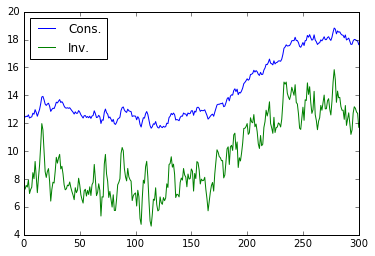

In [5]:
# This is the right panel of Fig 5.7.1 from p.105 of HS2013
plt.plot(Econ1.c[0],label='Cons.')
plt.plot(Econ1.i[0],label='Inv.')
plt.legend(loc='Best')

Inspection of the plot shows that the sample paths of consumption and investment drift in the fashion of a random walk. This is confirmed by checking the eigenvalues of $A^o$:

In [6]:
Econ1.endo, Econ1.exo

(array([ 0.9,  1. ]), array([ 1. ,  0.8,  0.5]))

The endogenous eigenvalue that appears to be unity reflects the random walk character of consumption in Hall's model. In fact, the eigenvalue is very slightly below 1, due to the small adjustment cost $\phi_1$:

In [7]:
Econ1.endo[1]

0.99999999999047617

Consequently, it is possible to compute the non-stochastic steady state of consumption, investment and capital in this model:

In [8]:
Econ1.compute_steadystate()
np.set_printoptions(precision=3,suppress=True)
print(Econ1.css, Econ1.iss, Econ1.kss)

[[ 5.]] [[ 0.]] [[ 0.001]]


However, the near-unity endogenous eigenvalue means that these steady state values are of little importance.

### Example 2: Altered growth condition
We generate our next economy by making two alterations to the parameters of Example 1.

First, we raise $\phi_1$ from 0.00001 to 1. This will lower the endogenous eigenvalue that is close to 1, causing the economy to head more quickly to the vicinity of its non-stochastic steady-state.

Second, we raise $\gamma_1$ from 0.1 to 0.15. This has the effect of raising the optimal steady-state value of capital.

We also start the economy off from an initial condition with a lower capital stock:
$$x_0 = 
   \left[ {\begin{array}{ccccc}
   5 & 20 & 1 & 0 & 0
   \end{array} } 
   \right]'
$$

Therefore, we need to define the following new parameters:

In [9]:
gamma2 = 0.15
gamma22 = np.array([[gamma2],[0]])

phi12 = 1
phii2 = np.array([[1],[-phi12]])

Tech2 = (phic,phig,phii2,gamma22,deltak,thetak)

x02 = np.array([[5],[20],[1],[0],[0]])

Creating the DLE class and then simulating gives the following plot for consumption and investment:

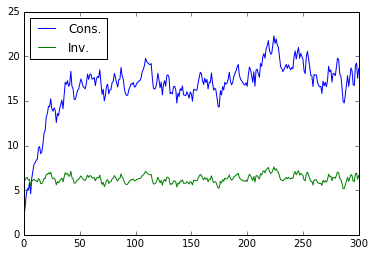

In [10]:
Econ2 = DLE(Info1, Tech2, Pref1)

Econ2.compute_sequence(x02,ts_length = 300)

plt.plot(Econ2.c[0],label='Cons.')
plt.plot(Econ2.i[0],label='Inv.')
plt.legend(loc='Best')

Simulating our new economy shows that consumption grows quickly in the early stages of the sample. However, it then settles down around the new non-stochastic steady-state level of consumption of 17.5, which we find as follows:

In [11]:
Econ2.compute_steadystate()
print(Econ2.css, Econ2.iss, Econ2.kss)

[[ 17.5]] [[ 6.25]] [[ 125.]]


The economy converges faster to this level than in Example 1 as the largest endogenous eigenvalue of $A^o$ is now significantly lower than 1:

In [12]:
Econ2.endo, Econ2.exo

(array([ 0.9  ,  0.952]), array([ 1. ,  0.8,  0.5]))

### Example 3: A Jones-Manuelli (1990) Economy
For our third economy, we choose parameter values with the aim of generating *sustained* growth in consumption, investment and capital. 

To do this, we set parameters such that Jones and Manuelli's "growth condition" is just satisfied. In our notation, just satisfying the growth condition is actually equivalent to setting $\beta(\gamma_1 + \delta_k) = 1$, the condition that was necessary for consumption to be a random walk in Hall's model. Thus, we lower $\gamma_1$ back to 0.1.

In our model, this is a necessary but not sufficient condition for growth. To generate growth we set preference parameters to reflect habit persistence. In particular, we set $\lambda = -1$, $\delta_h = 0.9$ and $\theta_h = 1 - \delta_h = 0.1$.

This makes preferences assume the form:

$$- \frac{1}{2}\mathbb{E}\sum_{t=0}^\infty \beta^t [(c_t-b_t - (1-\delta_h)\sum_{j=0}^\infty \delta_h^jc_{t-j-1})^2 + l_t^2]$$

These preferences reflect habit persistence, as the effective "bliss point" $b_t + (1-\delta_h)\sum_{j=0}^\infty \delta_h^jc_{t-j-1}$now shifts in response to a moving average of past consumption. 

As $\delta_h$ and $\theta_h$ were defined earlier, the only change we need to make from the parameters of Example 1 is to define the new value of $\lambda$:

In [13]:
llambda2 = np.array([[-1]])
Pref2 = (beta,llambda2,pih,deltah,thetah)

In [14]:
Econ3 = DLE(Info1, Tech1, Pref2)

We simulate this economy from the original state vector:

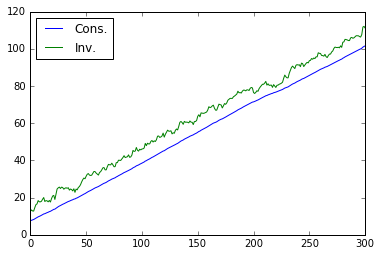

In [15]:
Econ3.compute_sequence(x0,ts_length = 300)

# This is the right panel of Fig 5.10.1 from p.110 of HS2013
plt.plot(Econ3.c[0],label='Cons.')
plt.plot(Econ3.i[0],label='Inv.')
plt.legend(loc='Best')

Thus, adding habit persistence to the Hall model of Example 1 is enough to generate sustained growth in our economy. The eigenvalues of $A^o$ in this new economy are:

In [16]:
Econ3.endo, Econ3.exo

(array([ 1.+0.j,  1.-0.j]), array([ 1. ,  0.8,  0.5]))

We now have two unit endogenous eigenvalues. One stems from satisfying the growth condition (as in Example 1). The other results from setting $\lambda = -1$. To show the importance of both of these for generating growth, we consider the following experiments:

#### Example 3.1: Raise $\lambda$ to -0.7

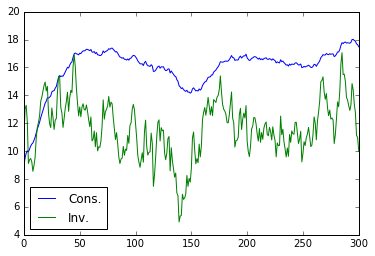

In [17]:
llambda3 = np.array([[-0.7]])
Pref3 = (beta,llambda3,pih,deltah,thetah)

Econ4 = DLE(Info1, Tech1, Pref3)

Econ4.compute_sequence(x0,ts_length = 300)

plt.plot(Econ4.c[0],label='Cons.')
plt.plot(Econ4.i[0],label='Inv.')
plt.legend(loc='Best')

We no longer achieve sustained growth if $\lambda$ is raised from -1 to -0.7. This is related to the fact that one of the endogenous eigenvalues is now less than 1:

In [18]:
Econ4.endo, Econ4.exo

(array([ 0.97,  1.  ]), array([ 1. ,  0.8,  0.5]))

#### Example 3.2: Lower $\beta$ to 0.94

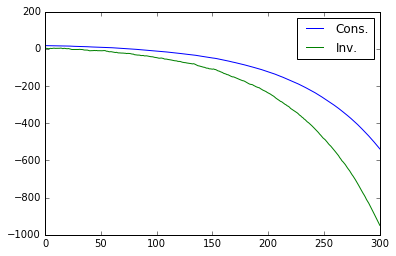

In [19]:
beta2 = np.array([[0.94]])
Pref4 = (beta2,llambda,pih,deltah,thetah)

Econ5 = DLE(Info1, Tech1, Pref4)

Econ5.compute_sequence(x0,ts_length = 300)

plt.plot(Econ5.c[0],label='Cons.')
plt.plot(Econ5.i[0],label='Inv.')
plt.legend(loc='Best')

Growth also fails if we lower $\beta$, as we now have $\beta(\gamma_1 + \delta_k) < 1$. Consumption and investment explode downwards, as a lower value of $\beta$ causes the representative consumer to front-load consumption. This explosive path shows up in the second endogeous eigenvalue now being larger than one:

In [20]:
Econ5.endo, Econ5.exo

(array([ 0.9  ,  1.013]), array([ 1. ,  0.8,  0.5]))